### 1_Health_Workforce_Migration_AgglomerativeClustering

### Import

In [503]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew

from pyclustertend import hopkins
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.style.use('classic')
sns.set_style("white")

### Data Scraping Oecd

In [504]:
# SDMX DATA URL: https://stats.oecd.org/restsdmx/sdmx.ashx/GetData/HEALTH_WFMI/AUS+AUT+BEL+CAN+CHL+COL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+IRL+ISR+ITA+KOR+LVA+LTU+LUX+NLD+NZL+NOR+POL+PRT+SVK+SVN+ESP+SWE+CHE+TUR+GBR+USA.DTRD+FTDS+UUUD+TNBD+IFTD+DTRN+FTNS+UUUN+TNBN+IFTN.TOT/all?startTime=2010&endTime=2019

In [505]:
import pandasdmx as pdmx
oecd = pdmx.Request("OECD")
data_resource_id="HEALTH_WFMI"
data_key="AUS+AUT+BEL+CAN+CHL+COL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+IRL+ISR+ITA+KOR+LVA+LTU+LUX+NLD+NZL+NOR+POL+PRT+SVK+SVN+ESP+SWE+CHE+TUR+GBR+USA.DTRD+FTDS+UUUD+TNBD+IFTD+DTRN+FTNS+UUUN+TNBN+IFTN.TOT/all?startTime=2010&endTime=2019"
data = oecd.data(resource_id=data_resource_id, key=data_key)
data = data.to_pandas()
df = pd.DataFrame(data).reset_index()
df.head()

,COU,VAR,CO2,TIME_PERIOD,value
0,AUS,DTRD,TOT,2012,46938.0
1,AUS,DTRD,TOT,2013,48405.0
2,AUS,DTRD,TOT,2014,51210.0
3,AUS,DTRD,TOT,2015,53503.0
4,AUS,DTRD,TOT,2016,55727.0


In [ ]:
#df.to_csv("health_workforce_migration.csv")

### Data Info

In [506]:
df.head(2)

,COU,VAR,CO2,TIME_PERIOD,value
0,AUS,DTRD,TOT,2012,46938.0
1,AUS,DTRD,TOT,2013,48405.0


In [507]:
df.shape

(2283, 5)

In [508]:
df = df.pivot(index=["COU","TIME_PERIOD"], columns="VAR", values=["value"])
df.columns = df.columns.droplevel()
df = df.rename_axis(None, axis=1)
df = df.reset_index()
df.head(1)

,COU,TIME_PERIOD,DTRD,DTRN,FTDS,FTNS,IFTD,IFTN,TNBD,TNBN,UUUD,UUUN
0,AUS,2012,46938.0,NaN,24892.0,NaN,NaN,NaN,75258.0,NaN,3427.0,NaN


In [509]:
# 'TNBD' : 'Total number of doctors'
# 'DTRD' : 'Domestically-trained doctors'
# 'FTDS' : 'Foreign-trained doctors - Stock'
# 'UUUD' : 'Unknown place of training (doctors)'
# 'IFTD' : 'Foreign-trained doctors - Annual inflow'
# 'TNBN' : 'Total number of nurses'
# 'DTRN' : 'Domestically-trained nurses'
# 'FTNS' : 'Foreign-trained nurses - Stock'
# 'UUUN' : 'Unknown place of training (nurses)'
# 'IFTN' : 'Foreign-trained nurses - Annual inflow'

In [510]:
df = df.iloc[:, [0, 1, 8, 2, 4, 10, 6, 9, 3, 5, 11, 7]]
df.rename(columns={"COU":"Country","TIME_PERIOD":"Time"}, inplace=True)
df.head(1)

,Country,Time,TNBD,DTRD,FTDS,UUUD,IFTD,TNBN,DTRN,FTNS,UUUN,IFTN
0,AUS,2012,75258.0,46938.0,24892.0,3427.0,NaN,NaN,NaN,NaN,NaN,NaN


In [511]:
df.shape

(320, 12)

In [512]:
df.isna().any().sum()

Country    False
Time       False
TNBD        True
DTRD        True
FTDS        True
UUUD        True
IFTD        True
TNBN        True
DTRN        True
FTNS        True
UUUN        True
IFTN        True
dtype: bool

In [513]:
df = df.fillna(0)

In [514]:
df.isna().any().sum()

Country    False
Time       False
TNBD       False
DTRD       False
FTDS       False
UUUD       False
IFTD       False
TNBN       False
DTRN       False
FTNS       False
UUUN       False
IFTN       False
dtype: bool

In [515]:
df.duplicated().any()

False

In [516]:
print(df.Country.nunique())
print(df.Country.unique())
# Totally 35 Countries

35
['AUS' 'AUT' 'BEL' 'CAN' 'CHE' 'CHL' 'COL' 'CRI' 'CZE' 'DEU' 'DNK' 'ESP'
 'EST' 'FIN' 'FRA' 'GBR' 'GRC' 'HUN' 'IRL' 'ISL' 'ISR' 'ITA' 'KOR' 'LTU'
 'LVA' 'NLD' 'NOR' 'NZL' 'POL' 'PRT' 'SVK' 'SVN' 'SWE' 'TUR' 'USA']


In [517]:
print(df.Time.nunique())
print(df.Time.unique())
# Totally 10 Years

10
['2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2010' '2011']


In [518]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  320 non-null    object 
 1   Time     320 non-null    object 
 2   TNBD     320 non-null    float64
 3   DTRD     320 non-null    float64
 4   FTDS     320 non-null    float64
 5   UUUD     320 non-null    float64
 6   IFTD     320 non-null    float64
 7   TNBN     320 non-null    float64
 8   DTRN     320 non-null    float64
 9   FTNS     320 non-null    float64
 10  UUUN     320 non-null    float64
 11  IFTN     320 non-null    float64
dtypes: float64(10), object(2)
memory usage: 30.1+ KB


In [519]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TNBD,320.0,84745.375000,144502.715561,0.0,14212.25,34419.5,86739.00,862965.0
DTRD,320.0,60390.721875,112973.036343,0.0,6589.25,23367.5,56863.75,647335.0
FTDS,320.0,12706.943750,31163.675475,0.0,537.75,3247.5,11063.00,215630.0
UUUD,320.0,470.700000,1444.821570,0.0,0.00,0.0,30.25,10254.0
IFTD,320.0,1106.287500,1792.252426,0.0,46.75,278.5,1331.00,11020.0
TNBN,320.0,156645.959375,302125.568087,0.0,0.00,54740.5,178922.50,2928810.0
DTRN,320.0,137842.109375,279022.719729,0.0,0.00,42791.0,164159.75,2732580.0
FTNS,320.0,10538.412500,23918.146606,0.0,0.00,812.0,8338.25,196230.0
UUUN,320.0,4362.734375,19422.158862,0.0,0.00,0.0,128.25,169088.0
IFTN,320.0,896.315625,1738.243436,0.0,3.00,99.5,892.50,10791.0


### Skewness

In [520]:
x = df.drop(columns=["Country", "Time"]).columns
for i in x:
    y = skew(df[i], nan_policy="omit")
    if y >= -0.5 and y < 0.5:
        print(f"{i} \t: {y} \t>>> Normal")
    elif y >= 0.5 and y < 1.0:
        print(f"{i} \t: {y} \t>>> Moderate")
    elif y >= 1.0:
        print(f"{i} \t: {y} \t>>> Skewed")       

TNBD 	: 3.4369166556347426 	>>> Skewed
DTRD 	: 3.476910389020295 	>>> Skewed
FTDS 	: 5.315591265289661 	>>> Skewed
UUUD 	: 4.11264544903352 	>>> Skewed
IFTD 	: 2.497337943931454 	>>> Skewed
TNBN 	: 5.102116867106194 	>>> Skewed
DTRN 	: 5.3505612849352095 	>>> Skewed
FTNS 	: 3.824135302782676 	>>> Skewed
UUUN 	: 6.303702534881367 	>>> Skewed
IFTN 	: 3.0923417756550853 	>>> Skewed


In [521]:
x = df.drop(columns=["Country", "Time"]).columns
for i in x:
    a = df[i].mean()
    b = df[i].median()
    if a == b:
        print(f"{i} \t: Normal Skewed")
    elif a > b:
        print(f"{i} \t: Right Skewed")
    elif a < b:
        print(f"{i} \t: Left Skewed")

TNBD 	: Right Skewed
DTRD 	: Right Skewed
FTDS 	: Right Skewed
UUUD 	: Right Skewed
IFTD 	: Right Skewed
TNBN 	: Right Skewed
DTRN 	: Right Skewed
FTNS 	: Right Skewed
UUUN 	: Right Skewed
IFTN 	: Right Skewed


### Heatmap

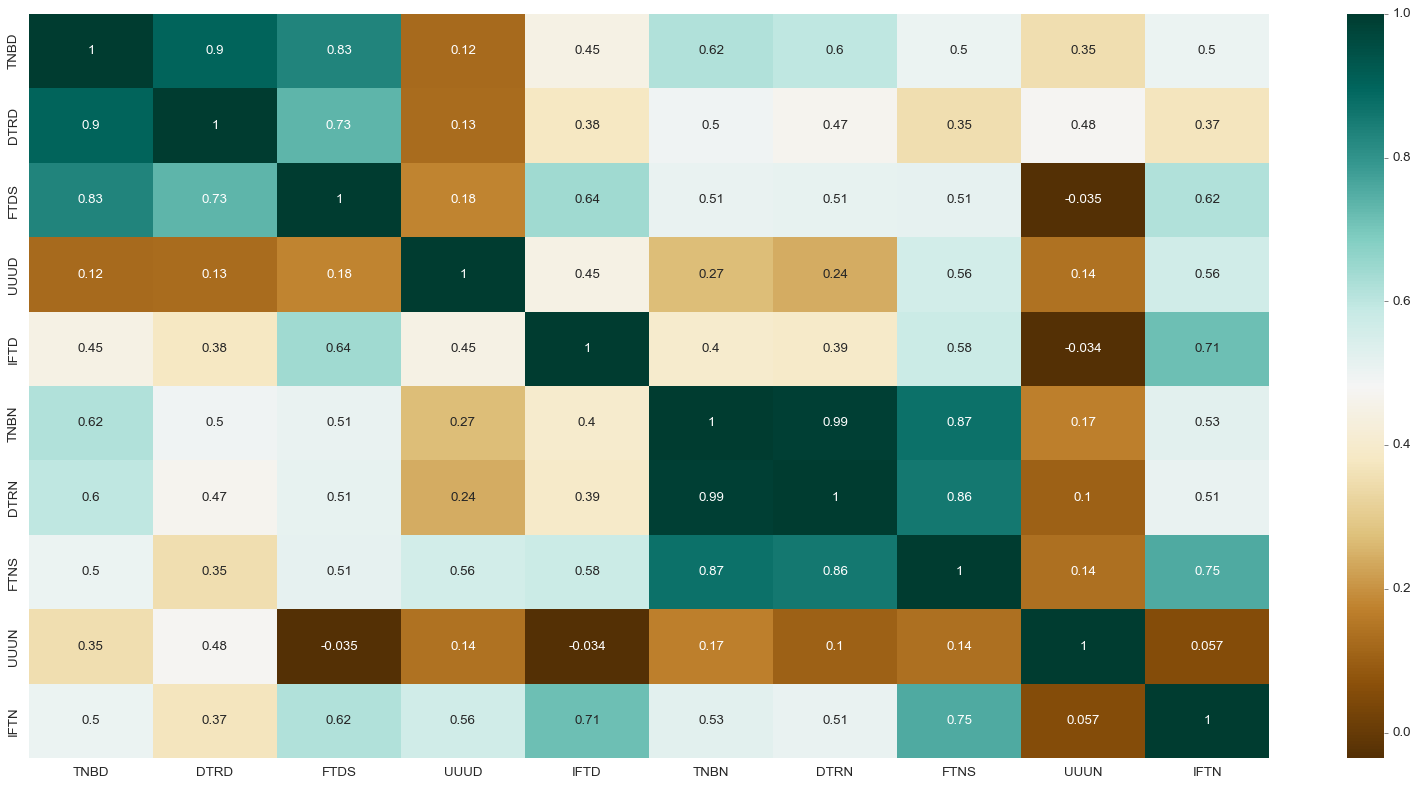

In [522]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, cmap="BrBG")
plt.tight_layout();

### Barplot

In [523]:
# fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(10,100))
# a = range(9)

# for i in a:
#     sns.barplot(x=df[df.columns[i+2]], y=df.Country, data=df, ax = ax[i])
#     for p in ax[i].patches:
#         ax[i].annotate(round((p.get_height())), (p.get_x()+0.22, p.get_height()+1.0))
# plt.tight_layout();

## AgglomerativeClustering

In [524]:
df.head(1)

,Country,Time,TNBD,DTRD,FTDS,UUUD,IFTD,TNBN,DTRN,FTNS,UUUN,IFTN
0,AUS,2012,75258.0,46938.0,24892.0,3427.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train Test Split

In [525]:
x = df.drop(["Country", "Time"], axis=1)
x.head(1)

,TNBD,DTRD,FTDS,UUUD,IFTD,TNBN,DTRN,FTNS,UUUN,IFTN
0,75258.0,46938.0,24892.0,3427.0,0.0,0.0,0.0,0.0,0.0,0.0


### Scaling

In [526]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_min = scaler.fit_transform(x)
x_min = pd.DataFrame(data=x_min, columns=df.columns[2:])
x_min.head(2)

,TNBD,DTRD,FTDS,UUUD,IFTD,TNBN,DTRN,FTNS,UUUN,IFTN
0,0.087209,0.072510,0.115438,0.334211,0.0,0.000000,0.00000,0.000000,0.000000,0.0
1,0.090356,0.074776,0.107402,0.625122,0.0,0.087813,0.07072,0.225669,0.116253,0.0


In [527]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_std = scaler.fit_transform(x)
x_std = pd.DataFrame(data=x_std, columns=df.columns[2:])
x_std.head(2)

,TNBD,DTRD,FTDS,UUUD,IFTD,TNBN,DTRN,FTNS,UUUN,IFTN
0,-0.065758,-0.119266,0.391614,2.049340,-0.618228,-0.519292,-0.494791,-0.441293,-0.224978,-0.516452
1,-0.046933,-0.106260,0.335918,4.117188,-0.618228,0.333307,0.198886,1.413046,0.788698,-0.516452


### Hopkins

In [528]:
from pyclustertend import hopkins
print(f"No Scale \t: {hopkins(x, x.shape[0])}")
print(f"MinMax Scale \t: {hopkins(x_min, x_min.shape[0])}")
print(f"StdScl Scale \t: {hopkins(x_std, x_std.shape[0])}")
# Suitable for Clustering >>> close to zero >>> Do Not Use Scaling

No Scale 	: 0.0061461649442121746
MinMax Scale 	: 0.027002939898447858
StdScl Scale 	: 0.023060331761617887


### Dendrogram

**“linkage” parameter: (default= “ward”)**

  {‘ward’, ‘complete’, ‘average’, ‘single’}

Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. 
-	Ward minimizes the variance of the clusters being merged.
-	Average uses the average of the distances of each observation of the two sets.
-	Complete or maximum linkage uses the maximum distances between all observations of the two sets.
-	Single uses the minimum of the distances between all observations of the two sets.


In [529]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [530]:
hc_ward = linkage(y = x, method = "ward")
hc_complete = linkage(x, "complete")
hc_average = linkage(x, "average")
hc_single = linkage(x, "single")

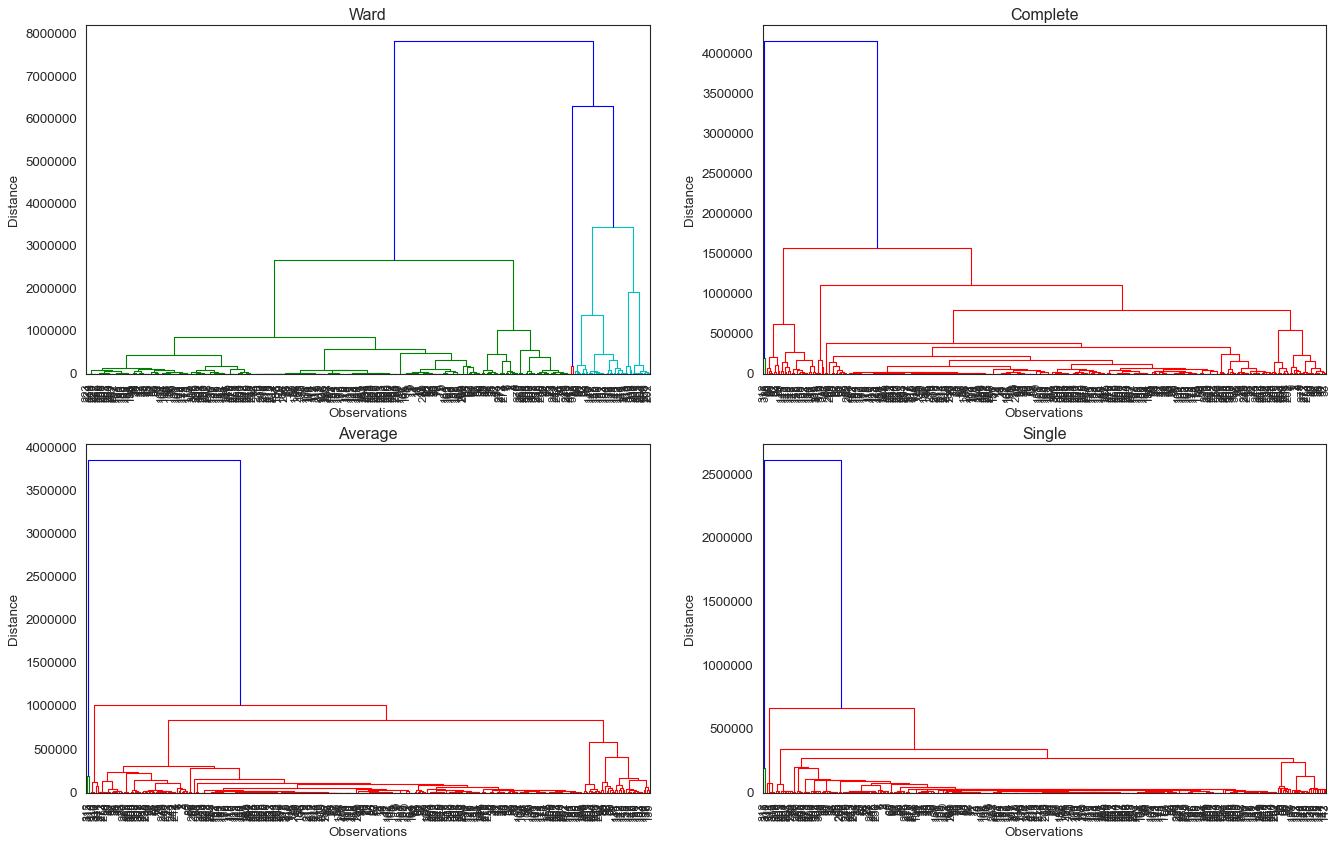

In [531]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size = 10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size = 10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size = 10);

In [532]:
# Ward is the best to decide the "k"=3

### AgglomerativeClustering (Hierarchical)

In [533]:
from sklearn.cluster import AgglomerativeClustering

### Silhouette

In [534]:
from sklearn.metrics import silhouette_score

In [535]:
K = range(2,10)

for k in K:
    model = AgglomerativeClustering(n_clusters = k)
    model.fit_predict(x)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(x, model.labels_)}')

Silhouette Score for 2 clusters: 0.7544854570318555
Silhouette Score for 3 clusters: 0.7543873738438058
Silhouette Score for 4 clusters: 0.767875966412294
Silhouette Score for 5 clusters: 0.6701535492500705
Silhouette Score for 6 clusters: 0.6867398717096861
Silhouette Score for 7 clusters: 0.6963608298234469
Silhouette Score for 8 clusters: 0.6470139335376748
Silhouette Score for 9 clusters: 0.510370409490972


In [536]:
# Due to the Silhoutte Score also we can decide "k"=3

### Model

In [537]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage = "ward")
model.fit_predict(x)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [538]:
model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [539]:
df["Class"] = model.labels_
df.head()

,Country,Time,TNBD,DTRD,FTDS,UUUD,IFTD,TNBN,DTRN,FTNS,UUUN,IFTN,Class
0,AUS,2012,75258.0,46938.0,24892.0,3427.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,AUS,2013,77974.0,48405.0,23159.0,6410.0,0.0,257189.0,193249.0,44283.0,19657.0,0.0,1
2,AUS,2014,80968.0,51210.0,25694.0,4064.0,2685.0,264876.0,210980.0,48533.0,5363.0,3444.0,1
3,AUS,2015,83490.0,53503.0,27008.0,2979.0,2717.0,271151.0,217108.0,49126.0,4917.0,2008.0,1
4,AUS,2016,86550.0,55727.0,28283.0,2540.0,2726.0,279789.0,224447.0,51180.0,4162.0,2695.0,1


### Visualization Clusters

In [540]:
df[df["Class"]==0].Country.unique()

array(['DEU', 'FRA', 'GBR', 'ITA', 'USA'], dtype=object)

In [541]:
df[df["Class"]==1].Country.unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CHL', 'COL', 'CRI', 'CZE',
       'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'GRC', 'HUN', 'IRL', 'ISL',
       'ISR', 'KOR', 'LTU', 'LVA', 'NLD', 'NOR', 'NZL', 'POL', 'PRT',
       'SVK', 'SVN', 'SWE', 'TUR', 'USA'], dtype=object)

In [542]:
df[df["Class"]==2].Country.unique()

array(['USA'], dtype=object)

In [543]:
# 'TNBD' : 'Total number of doctors'
# 'DTRD' : 'Domestically-trained doctors'
# 'FTDS' : 'Foreign-trained doctors - Stock'
# 'UUUD' : 'Unknown place of training (doctors)'
# 'IFTD' : 'Foreign-trained doctors - Annual inflow'
# 'TNBN' : 'Total number of nurses'
# 'DTRN' : 'Domestically-trained nurses'
# 'FTNS' : 'Foreign-trained nurses - Stock'
# 'UUUN' : 'Unknown place of training (nurses)'
# 'IFTN' : 'Foreign-trained nurses - Annual inflow'

In [544]:
# 0 = 'DEU', 'FRA', 'GBR', 'ITA', 'USA'

# 1 = 'AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CHL', 'COL', 'CRI', 'CZE',
#     'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'GRC', 'HUN', 'IRL', 'ISL',
#     'ISR', 'KOR', 'LTU', 'LVA', 'NLD', 'NOR', 'NZL', 'POL', 'PRT',
#     'SVK', 'SVN', 'SWE', 'TUR', 'USA'

# 2 = 'USA'

In [545]:
df.head(1)

,Country,Time,TNBD,DTRD,FTDS,UUUD,IFTD,TNBN,DTRN,FTNS,UUUN,IFTN,Class
0,AUS,2012,75258.0,46938.0,24892.0,3427.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [546]:
df1 = df.set_index("Country")
df1 = df1.drop(["Time", "Class"], axis=1)
df1.head()

,TNBD,DTRD,FTDS,UUUD,IFTD,TNBN,DTRN,FTNS,UUUN,IFTN
Country,,,,,,,,,,
AUS,75258.0,46938.0,24892.0,3427.0,0.0,0.0,0.0,0.0,0.0,0.0
AUS,77974.0,48405.0,23159.0,6410.0,0.0,257189.0,193249.0,44283.0,19657.0,0.0
AUS,80968.0,51210.0,25694.0,4064.0,2685.0,264876.0,210980.0,48533.0,5363.0,3444.0
AUS,83490.0,53503.0,27008.0,2979.0,2717.0,271151.0,217108.0,49126.0,4917.0,2008.0
AUS,86550.0,55727.0,28283.0,2540.0,2726.0,279789.0,224447.0,51180.0,4162.0,2695.0


In [547]:
df1.shape

(320, 10)

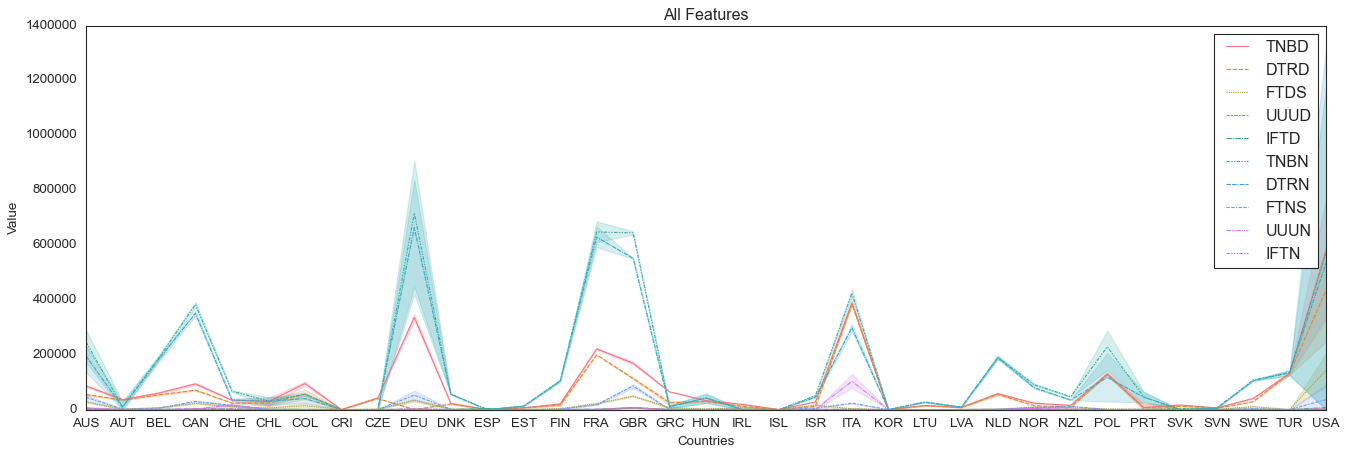

In [548]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df1)
plt.title("All Features")
plt.xlabel("Countries")
plt.ylabel("Value")
plt.tight_layout;

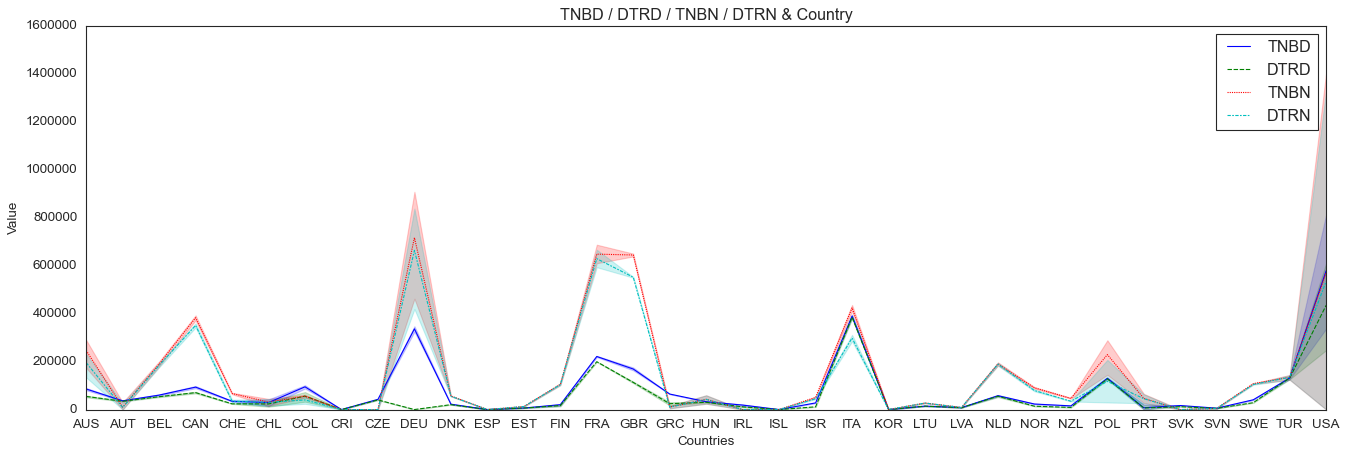

In [549]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df1[["TNBD","DTRD","TNBN", "DTRN"]])
plt.title("TNBD / DTRD / TNBN / DTRN & Country")
plt.xlabel("Countries")
plt.ylabel("Value")
plt.tight_layout;

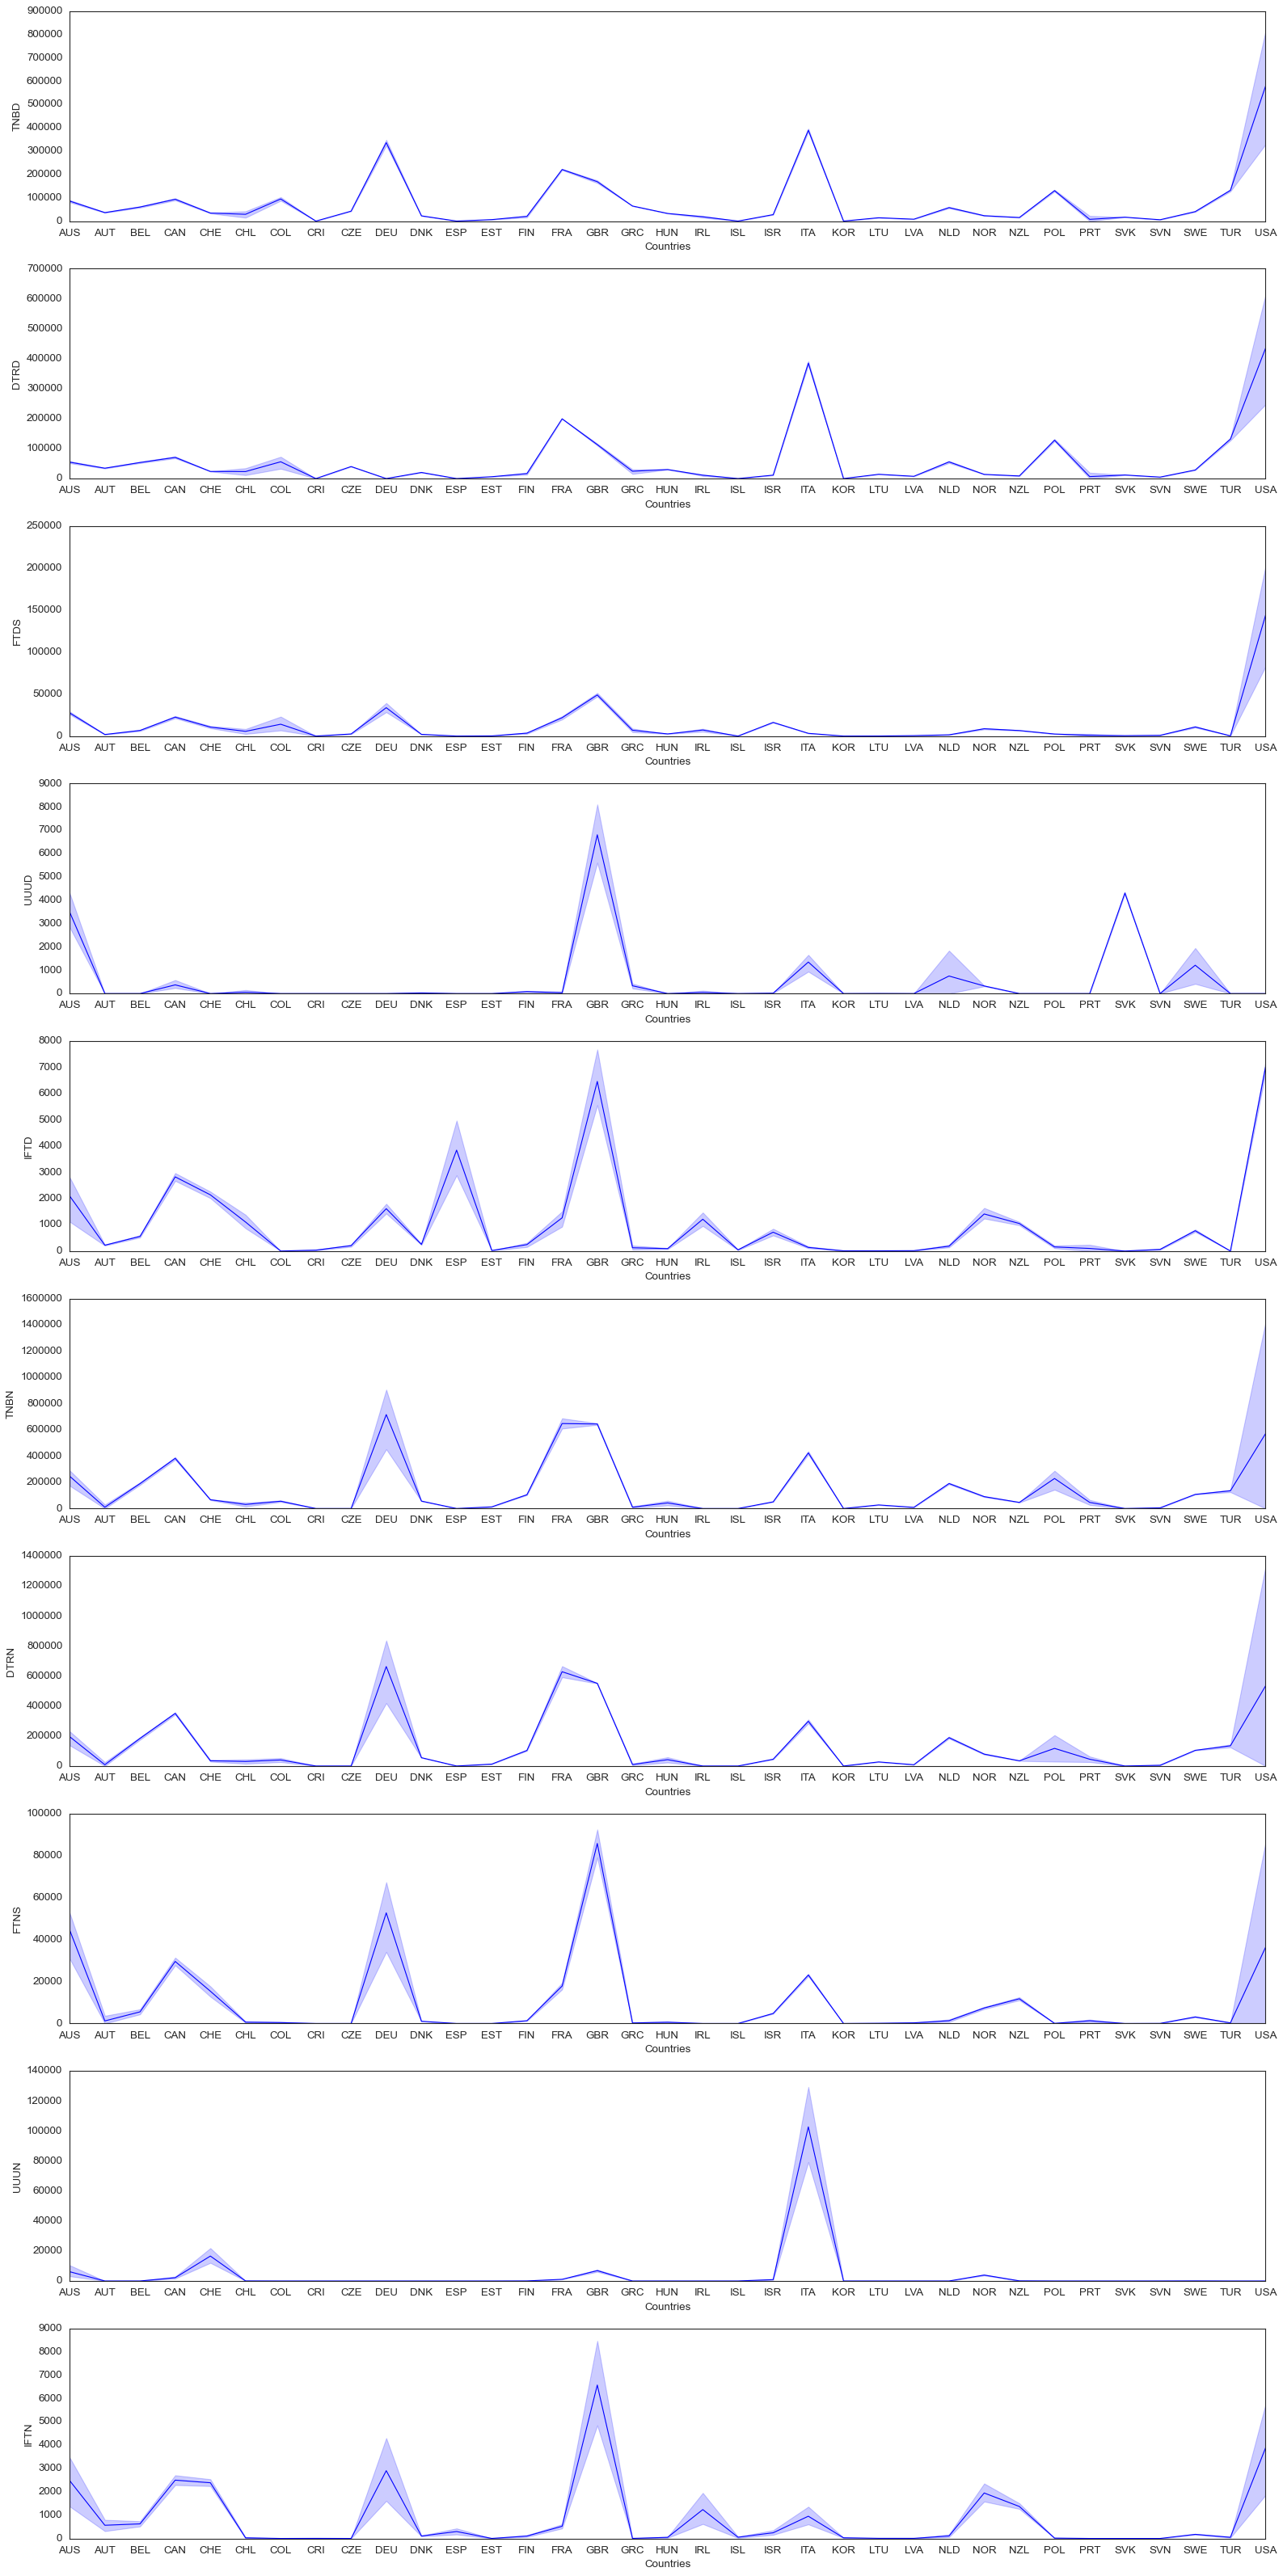

In [550]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(20,40), sharey=False, sharex=False)

for i in range(10):       
    sns.lineplot(data=df1.iloc[:,i], ax=ax[i], palette="muted")
    ax[i].set_xlabel("Countries")
    ax[i].set_ylabel(df1.columns[i])

plt.tight_layout();

### Feature Selection

In [551]:
df2 = df.drop(columns=["Country","Time"]).groupby("Class").mean().T
df2

Class,0,1,2
TNBD,340369.093023,39242.349091,845501.5
DTRD,233750.162791,29105.261818,634913.5
FTDS,47741.906977,5789.614545,210588.0
UUUD,1904.000000,250.007273,0.0
IFTD,2925.046512,779.330909,6959.5
TNBN,565472.627907,73101.541818,2854230.0
DTRN,498014.720930,63088.694545,2672725.5
FTNS,41717.418605,4419.760000,181504.5
UUUN,25763.744186,1048.123636,0.0
IFTN,3167.023256,503.112727,6141.5


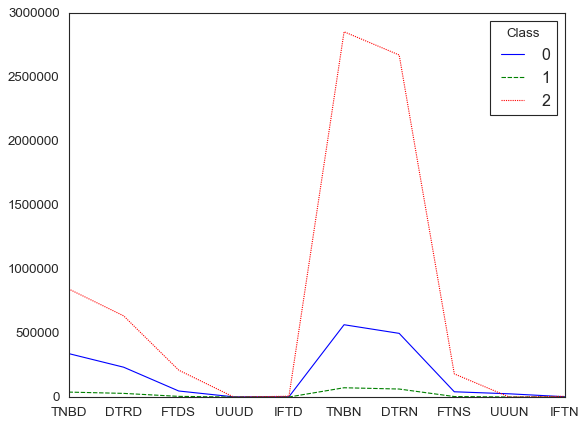

In [552]:
sns.lineplot(data = df2);

In [555]:
# Feature Selection >>> TNBD, DTRD, TNBN, DTRN

### New Dataset

In [556]:
df.head(1)

,Country,Time,TNBD,DTRD,FTDS,UUUD,IFTD,TNBN,DTRN,FTNS,UUUN,IFTN,Class
0,AUS,2012,75258.0,46938.0,24892.0,3427.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [558]:
df_last = df.iloc[:, [2, 3, 7, 8]]
df_last.head(1)

,TNBD,DTRD,TNBN,DTRN
0,75258.0,46938.0,0.0,0.0


### Hopkins & New Data

In [561]:
from pyclustertend import hopkins
hopkins(df_last, len(df_last))

0.005701031424230596

### Dendrogram & New Data

In [562]:
hc_ward = linkage(y = df_last, method = "ward")
hc_complete = linkage(df_last, "complete")
hc_average = linkage(df_last, "average")
hc_single = linkage(df_last, "single")

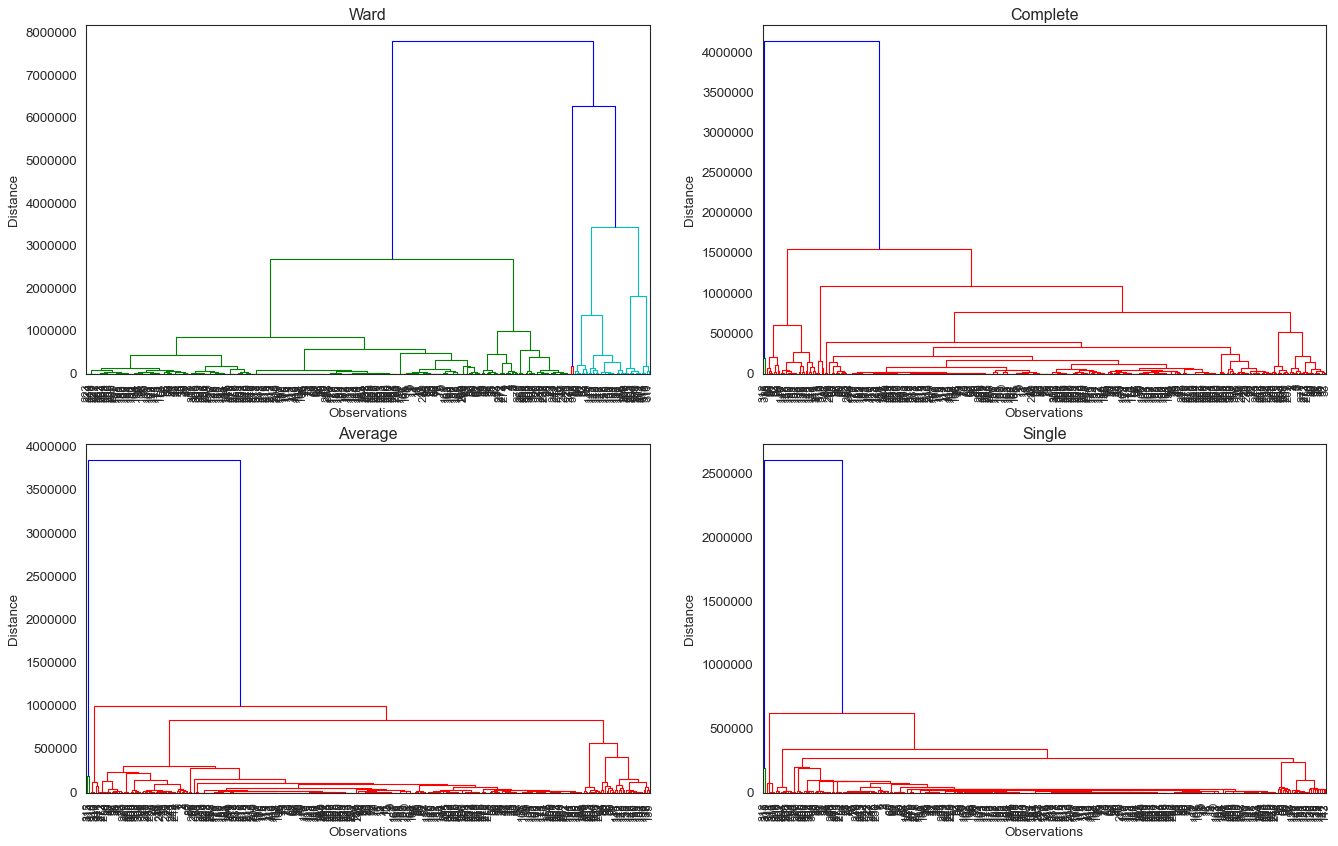

In [563]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size = 10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size = 10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size = 10);

### Silhouette & New Data

In [564]:
K = range(2,10)

for k in K:
    model = AgglomerativeClustering(n_clusters = k)
    model.fit_predict(df_last)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(df_last, model.labels_)}')

Silhouette Score for 2 clusters: 0.7555941639111106
Silhouette Score for 3 clusters: 0.7554532100831732
Silhouette Score for 4 clusters: 0.7682021609910736
Silhouette Score for 5 clusters: 0.6759894082447957
Silhouette Score for 6 clusters: 0.6911873981985062
Silhouette Score for 7 clusters: 0.7024615906722168
Silhouette Score for 8 clusters: 0.6525585699011138
Silhouette Score for 9 clusters: 0.5191278262354602


### Last Model & New Data & "k"=3

In [566]:
df.head(1)

,Country,Time,TNBD,DTRD,FTDS,UUUD,IFTD,TNBN,DTRN,FTNS,UUUN,IFTN,Class
0,AUS,2012,75258.0,46938.0,24892.0,3427.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [565]:
model_last = AgglomerativeClustering(n_clusters=3, affinity = "euclidean", linkage = "ward")
clusters = model_last.fit_predict(df_last)

In [567]:
df_last["Class_df"] = df["Class"]
df_last["Class_df_last"] = clusters
df_last.head()

,TNBD,DTRD,TNBN,DTRN,Class_df,Class_df_last
0,75258.0,46938.0,0.0,0.0,1,1
1,77974.0,48405.0,257189.0,193249.0,1,1
2,80968.0,51210.0,264876.0,210980.0,1,1
3,83490.0,53503.0,271151.0,217108.0,1,1
4,86550.0,55727.0,279789.0,224447.0,1,1


In [568]:
crstb = pd.crosstab(df_last["Class_df"], df_last["Class_df_last"])
crstb

Class_df_last,0,1,2
Class_df,,,
0,43,0,0
1,0,275,0
2,0,0,2


In [ ]:
# With df and df_last, the clustering are the same result

### Adjusted Rand Score For df & df_last

In [569]:
from sklearn.metrics.cluster import adjusted_rand_score

In [570]:
adjusted_rand_score(df_last["Class_df"], df_last["Class_df_last"])

1.0